### Survival analysis tests using Kaplan Meier probabilities 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings; warnings.simplefilter('ignore')

import sys
# sys.path.insert(0, '/Users/matthew.cohen/Dev/DataRobot-my github repo/Survival Analysis')
import Kaplan_Meier as km

In [24]:
# df = pd.read_csv('DR_Demo_Banking_CustomerChurn.csv')

SOURCE_FILE = 'data/DR_Demo_Banking_CustomerChurn'
TRAIN_FILE = 'data/DR_Demo_Banking_CustomerChurn_train'
PRED_FILE = 'data/DR_Demo_Banking_CustomerChurn_pred'

df_full = pd.read_csv(SOURCE_FILE+'.csv', encoding = 'ISO-8859-1')
target = 'Churn'

# Shuffle the rows
df_full = df_full.sample(frac=1, random_state=0)

# Split 90% for training, 10% for predictions
split = int(df_full.shape[0] * .1)
df = df_full[split:]
df_pred = df_full[:split].copy()

# Drop the target from the prediction dataset
prediction_data = df_pred.drop(target, axis=1)

print('Full data shape:      ',df_full.shape)
print('Training data shape:  ',df.shape)
print('Prediction data shape:',prediction_data.shape)

df.to_csv(TRAIN_FILE+'.csv', index=False)
prediction_data.to_csv(PRED_FILE+'.csv', index=True)
# Plus write a pref file with the target
df_pred.to_csv(PRED_FILE+'_with_target.csv', index=True)

df.tail(5).transpose()

Full data shape:       (10000, 33)
Training data shape:   (9000, 33)
Prediction data shape: (1000, 32)


,9225,4859,3264,9845,2732
id_loan,F114Q2200611,F104Q2281741,F115Q2154437,F101Q4358630,F101Q1293482
CurrentBalance,414000,49210.5,195040,271816,225364
loan_age,5,16,10,9,30
delq_sts,0,0,0,0,0
Margin,-0.05,-0.6,-0.375,-0.175,0.35
countLatePayment,0,0,0,0,0
RefinanceRateRelativity,-0.270071,-0.43897,0.217619,0.116337,-1.31998
RealGDP,2.3,2.3,0.8,0.3,4.8
ChangeUnemploymentRate,-0.4,0,-0.1,0.2,-0.3
CurrentLCV,-312.042,-248.275,-987.519,-2038.65,-185.467


In [13]:
df = df.reset_index(drop=True)

In [14]:
# # Now make additions to the full set again to set up the data with Kaplan Meier probabilites
# # Shuffle the rows again
# df_full = df_full.sample(frac=1, random_state=0)

# # Split 90% for training, 10% for predictions
# split = int(df_full.shape[0] * .1)
# df = df_full[split:]
# df_pred = df_full[:split].copy()

df['b_churn'] = df.Churn.apply(lambda x: 1 if x == 'Yes' else 0)
df.b_churn.value_counts()

0    5834
1    3166
Name: b_churn, dtype: int64

In [15]:
# Pick a variable to segment for the purposes of using the same output as the medium article
# Loans with more or less than 20% down
df["b_downpayment_percent"] = df.ltv.apply(lambda x: 1 if x > 95 else 0)

In [16]:
df.b_churn.value_counts()

0    5834
1    3166
Name: b_churn, dtype: int64

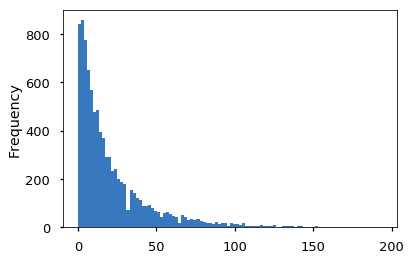

In [17]:
df.loan_age.plot(kind='hist',bins=100)

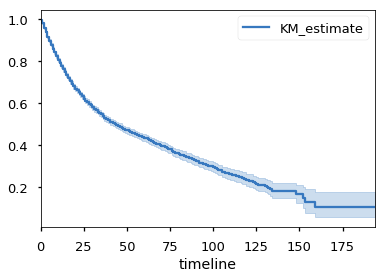

In [18]:
km.kaplan_meier(df, 'b_churn', 'loan_age')

In [20]:
# km.kaplan_meier(df, 'b_churn', 'loan_age', 'b_downpayment_percent', 
#                 segmentation_label=['5% or more down', 'less than 5% down'],
#                 ylim_min=0)

In [22]:
from lifelines import KaplanMeierFitter  # survival analysis library
from lifelines.statistics import logrank_test  # survival statistical testing
kmf = KaplanMeierFitter()
T = df['loan_age']  # duration
C = df['b_churn']  # censorship - 1 if death/churn is seen, 0 if censored

kmf.fit(T, C)

# Create feature for the km probability at a given time.
# However, We need to know which of the '0's are censored churns and which are non-churned
df['km_prob_of_event'] = kmf.cumulative_density_at_times(df['loan_age']).values
df['km_prob_of_event'] = np.where(df.b_churn == 1, 1, df.km_prob_of_event)

# Then double the rows for the zero, with the km_prob value being 1 - km_prob
# "The patient’s probability of recurrence is then Pr = 1 - Prf. The outcome for this
# patient is, therefore, a distribution (Prf, Pr). Since most of the machine learning
# tools do not include mechanisms to handle distributions as class values, instead of
# a single data record for each patient from the third group, two copies of the
# patient’s data are created, one labeled with an outcome ‘not-recurred’ and weighted
# with weight Prf, and the other with an outcome ‘recurred’ and weighted with weight
# Pr."

# df['dupe'] = None
df['dupe'] = np.where(df.b_churn == 0, 1-df.km_prob_of_event, None)
df_double_zeros = pd.concat([df, df[df['dupe'].notnull()]])
df_double_zeros['km_prob_of_event'] = np.where(df_double_zeros.dupe.isnull(), df_double_zeros.km_prob_of_event, df_double_zeros.dupe)
df_double_zeros.drop(['dupe'], axis=1, inplace=True)

# delete unused columns
del df_double_zeros['b_churn']
del df_double_zeros['b_downpayment_percent']

# Make the km_prob the weights column, so that one col is used as a weight, and one as value
# df_double_zeros['weights'] = df_double_zeros['km_prob_of_event']

# Write to csv tp upload into DR
df_double_zeros.to_csv(TRAIN_FILE+'_with_km.csv', index=False)
# df_double_zeros[['b_churn', 'loan_age', 'km_prob_of_event']].head(5)
df_double_zeros.columns
# df_double_zeros['b_churn']

Index(['id_loan', 'CurrentBalance', 'loan_age', 'delq_sts', 'Margin',
       'countLatePayment', 'RefinanceRateRelativity', 'RealGDP',
       'ChangeUnemploymentRate', 'CurrentLCV', 'fico', 'flag_fthb', 'cd_msa',
       'mi_pct', 'cnt_units', 'occpy_sts', 'cltv', 'dti', 'orig_upb', 'ltv',
       'int_rt', 'channel', 'ppmt_pnlty', 'prod_type', 'st', 'prop_type',
       'zipcode', 'loan_purpose', 'orig_loan_term', 'cnt_borr', 'flag_sc',
       'customerFeedback', 'Churn', 'km_prob_of_event'],
      dtype='object')

### Prediction Confusion Matrix

In [36]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def print_cm(y_true, y_pred):
    [[tn, fp], [fn, tp]] = confusion_matrix(y_true, y_pred)
    cm = [[tn, fp], [fn, tp]]
    print(cm[0])
    print(cm[1])
    print(classification_report(y_true, y_pred))

preds_ = pd.read_csv('predictions/eXtreme_Gradient_Boosted_Trees_Classifier_with_Ear_(87)_0.3276thresh.csv')
preds_['Churn'] = preds_['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)
y_true = preds_['Churn']
y_pred = preds_['PredictedLabel']
print_cm(y_true, y_pred)

preds_ = pd.read_csv('predictions/RandomForest_Classifier_(Entropy)_(64)_0.2899thresh.csv')
preds_['Churn'] = preds_['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)
y_true = preds_['Churn']
y_pred = preds_['PredictedLabel']
print_cm(y_true, y_pred)

[408, 230]
[110, 252]
             precision    recall  f1-score   support

          0       0.79      0.64      0.71       638
          1       0.52      0.70      0.60       362

avg / total       0.69      0.66      0.67      1000

[376, 262]
[109, 253]
             precision    recall  f1-score   support

          0       0.78      0.59      0.67       638
          1       0.49      0.70      0.58       362

avg / total       0.67      0.63      0.64      1000

